# GLOBAL TERRORISM - THE EVOLUTION OF TERRORIST ATTACKS IN THE LAST 20 YEARS

## SPARK - Individual Assignment
## Eleonora Jiménez Pulido

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 14px; }</style>")) # Increase font size

In [19]:
import sys
!{sys.executable} -m pip install seaborn

    100% |████████████████████████████████| 286kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 25.9MB 32kB/s  eta 0:00:01


In [330]:
import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from IPython.display import display, Markdown
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit, sum, count, round
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.window import Window

#libraries to implement the charts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas 
import numpy as np
import seaborn as sns


sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## 2. Data source and Spark data abstraction (DataFrame) setup

In [322]:
TerrorismDF = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("multiline", "true") \
                 .option("quote", '"') \
                 .option("delimiter", ',') \
                 .option("escape", "\\") \
                 .option("escape", '"') \
                 .csv("globalterrorismdb_0718dist.csv")


## 3. Data set metadata analysis

### 3.1. Subset Dataset and rename Columns

In [323]:
TerrorismDF = TerrorismDF.filter(TerrorismDF["iyear"]>1996)

TerrorismDF = TerrorismDF.withColumnRenamed('iyear', 'year')\
                         .withColumnRenamed('imonth', 'month')\
                         .withColumnRenamed('country', 'countryid')\
                         .withColumnRenamed('region', 'regionid')\
                         .withColumnRenamed('country_txt', 'country')\
                         .withColumnRenamed('region_txt', 'region')\
                         .withColumnRenamed('attacktype1_txt', 'AttackType')

### 3.1. Display schema and size of the DataFrame

In [324]:
TerrorismDF.printSchema()
display(Markdown("This DataFrame has **%d rows**." % TerrorismDF.count()))

root
 |-- eventid: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: string (nullable = true)
 |-- countryid: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- regionid: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: integer (nullable = true)
 |-- crit2: integer (nullable = true)
 |-- crit3: integer (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- alternative: integer (nullable = true)
 |-- alternative_txt: string (nullable 

This DataFrame has **117381 rows**.

## 4. Columns groups basic profiling to better understand our data set
### 4.1. Timing related columns basic profiling

In [293]:
print ("Summary of columns Year and Month:")
TerrorismDF.select("year","month").summary().show()

print("Checking for nulls on columns Year and Month:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["year","month"]]).show()

print("Checking amount of distinct values in columns Year and Month:")
TerrorismDF.select([countDistinct(c).alias(c) for c in ["year","month"]]).show()

print ("Most and least frequent occurrences for Year and Month columns:")
YearOccurrencesDF = TerrorismDF.groupBy("year").agg(count(lit(1)).alias("Total"))
MonthDF = TerrorismDF.groupBy("month").agg(count(lit(1)).alias("Total"))

leastFreqYear   = YearOccurrencesDF.orderBy(col("Total").asc()).first()
mostFreqYear    = YearOccurrencesDF.orderBy(col("Total").desc()).first()
leastFreqMonth  = MonthDF.orderBy(col("Total").asc()).first()
mostFreqMonth   = MonthDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqYear", "mostFreqYear", "leastFreqMonth", "mostFreqMonth", \
       "%d (%d occurrences)" % (leastFreqYear["year"], leastFreqYear["Total"]), \
       "%d (%d occurrences)" % (mostFreqYear["year"], mostFreqYear["Total"]), \
       "%d (%d occurrences)" % (leastFreqMonth["month"], leastFreqMonth["Total"]), \
       "%d (%d occurrences)" % (mostFreqMonth["month"], mostFreqMonth["Total"]))))


Summary of columns Year and Month:
+-------+------------------+------------------+
|summary|              year|             month|
+-------+------------------+------------------+
|  count|            117381|            117381|
|   mean|2011.5615729973335| 6.472810761537216|
| stddev| 5.094113607868744|3.3825629001190003|
|    min|              1997|                 1|
|    25%|              2009|                 4|
|    50%|              2013|                 6|
|    75%|              2015|                 9|
|    max|              2017|                12|
+-------+------------------+------------------+

Checking for nulls on columns Year and Month:
+----+-----+
|year|month|
+----+-----+
|   0|    0|
+----+-----+

Checking amount of distinct values in columns Year and Month:
+----+-----+
|year|month|
+----+-----+
|  21|   12|
+----+-----+

Most and least frequent occurrences for Year and Month columns:



| leastFreqYear | mostFreqYear | leastFreqMonth | mostFreqMonth |
|----|----|----|----|
| 1998 (934 occurrences) | 2014 (16903 occurrences) | 12 (8633 occurrences) | 5 (10821 occurrences) |


### 4.2. Attack related main columns basic profiling

In [366]:
print ("Summary of columns country, Region,  Success, attack type, gName, Motive, crit1:")
TerrorismDF.select("country", "region", "success", "AttackType",'crit1').summary().show()
TerrorismDF.select("gname", "motive").summary().show()

print("Checking for nulls on columns country, Region, Success, attack type, attack type name, gName, Motive, crit1:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) \
                    for c in ["countryid","country","regionid","region", "success", "attacktype1", "AttackType","gname", "motive",'crit1']]).show()

print("Checking amount of distinct values in columns country, Region, Success,  attack type, attack type name,  gName, Motive:")
TerrorismDF.select([countDistinct(c).alias(c) for c in ["countryid","country","regionid","region", "success", "attacktype1", "AttackType",\
                                                        "gname", "motive"]]).show()

# we omit the success column because it is boolean values
print ("Most and least frequent occurrences for country, Region, attacktype1, gName, Motive:")
CountryDF         = TerrorismDF.groupBy("countryid").agg(count(lit(1)).alias("Total"))
CountryNameDF     = TerrorismDF.groupBy("country").agg(count(lit(1)).alias("Total"))
RegionDF          = TerrorismDF.groupBy("regionid").agg(count(lit(1)).alias("Total"))
RegionNameDF      = TerrorismDF.groupBy("region").agg(count(lit(1)).alias("Total"))
AttackTypeDF      = TerrorismDF.groupBy("attacktype1").agg(count(lit(1)).alias("Total"))
AttackTypeNameDF  = TerrorismDF.groupBy("AttackType").agg(count(lit(1)).alias("Total"))
gNameDF           = TerrorismDF.groupBy("gname").agg(count(lit(1)).alias("Total"))
MotiveDF          = TerrorismDF.groupBy("motive").agg(count(lit(1)).alias("Total")) 

leastFreqCountry        = CountryDF.orderBy(col("Total").asc()).first()
mostFreqCountry         = CountryDF.orderBy(col("Total").desc()).first()
leastFreqCountryNm      = CountryNameDF.orderBy(col("Total").asc()).first()
mostFreqCountryNm       = CountryNameDF.orderBy(col("Total").desc()).first()
leastFreqRegion         = RegionDF.orderBy(col("Total").asc()).first()
mostFreqRegion          = RegionDF.orderBy(col("Total").desc()).first()
leastFreqRegionNm       = RegionNameDF.orderBy(col("Total").asc()).first()
mostFreqRegionNm        = RegionNameDF.orderBy(col("Total").desc()).first()
leastFreqAttackType     = AttackTypeDF.orderBy(col("Total").asc()).first()
mostFreqAttackType      = AttackTypeDF.orderBy(col("Total").desc()).first()
leastFreqAttackTypeNm   = AttackTypeNameDF.orderBy(col("Total").asc()).first()
mostFreqAttackTypeNm    = AttackTypeNameDF.orderBy(col("Total").desc()).first()
leastFreqGroupName      = gNameDF.orderBy(col("Total").asc()).first()
mostFreqGroupName       = gNameDF.orderBy(col("Total").desc()).first()
leastFreqMotive         = MotiveDF.orderBy(col("Total").asc()).first()
mostFreqMotive          = MotiveDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("least Freq Country", "most Freq Country", "least Freq Region", "most Freq Region","least Freq AttackType", "most Freq AttackType", \
       "%d (%d occurrences)" % (leastFreqCountry["countryid"], leastFreqCountry["Total"]), \
       "%d (%d occurrences)" % (mostFreqCountry["countryid"], mostFreqCountry["Total"]), \
       "%s (%d occurrences)" % (leastFreqRegion["regionid"], leastFreqRegion["Total"]), \
       "%s (%d occurrences)" % (mostFreqRegion["regionid"], mostFreqRegion["Total"]), \
       "%s (%d occurrences)" % (leastFreqAttackType["attacktype1"], leastFreqAttackType["Total"]), \
       "%s (%d occurrences)" % (mostFreqAttackType["attacktype1"], mostFreqAttackType["Total"]))))

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("least Freq Country", "most Freq Country", "least Freq Region", "most Freq Region","least Freq AttackType", "most Freq AttackType", \
       "%s (%d occurrences)" % (leastFreqCountryNm["country"], leastFreqCountryNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqCountryNm["country"], mostFreqCountryNm["Total"]), \
       "%s (%d occurrences)" % (leastFreqRegionNm["region"], leastFreqRegionNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqRegionNm["region"], mostFreqRegionNm["Total"]), \
       "%s (%d occurrences)" % (leastFreqAttackTypeNm["AttackType"], leastFreqAttackTypeNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqAttackTypeNm["AttackType"], mostFreqAttackTypeNm["Total"]))))

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("least Freq groupName", "most Freq GroupName", "least Freq Motive", "most Freq Motive", \
       "%s (%d occurrences)" % (leastFreqGroupName["gname"], leastFreqGroupName["Total"]), \
       "%s (%d occurrences)" % (mostFreqGroupName["gname"], mostFreqGroupName["Total"]), \
       "%s (%d occurrences)" % (leastFreqMotive["motive"], leastFreqMotive["Total"]), \
       "%s (%d occurrences)" % (mostFreqMotive["motive"], mostFreqMotive["Total"]))))


Summary of columns country, Region,  Success, attack type, gName, Motive, crit1:
+-------+-----------+--------------------+------------------+-------------+-------------------+
|summary|    country|              region|           success|   AttackType|              crit1|
+-------+-----------+--------------------+------------------+-------------+-------------------+
|  count|     117381|              117381|            117381|       117381|             117381|
|   mean|       null|                null|0.8753375759279611|         null| 0.9889505115819426|
| stddev|       null|                null|0.3303371516213381|         null|0.10453463692937752|
|    min|Afghanistan|Australasia & Oce...|                 0|Armed Assault|                  0|
|    25%|       null|                null|                 1|         null|                  1|
|    50%|       null|                null|                 1|         null|                  1|
|    75%|       null|                null|             


| least Freq Country | most Freq Country | least Freq Region | most Freq Region | least Freq AttackType | most Freq AttackType |
|----|----|----|----|----|----|
| 115 (1 occurrences) | 95 (24515 occurrences) | 12 (92 occurrences) | 10 (42189 occurrences) | 4 (339 occurrences) | 3 (61178 occurrences) |



| least Freq Country | most Freq Country | least Freq Region | most Freq Region | least Freq AttackType | most Freq AttackType |
|----|----|----|----|----|----|
| International (1 occurrences) | Iraq (24515 occurrences) | Australasia & Oceania (92 occurrences) | Middle East & North Africa (42189 occurrences) | Hijacking (339 occurrences) | Bombing/Explosion (61178 occurrences) |



| least Freq groupName | most Freq GroupName | least Freq Motive | most Freq Motive |
|----|----|----|----|
| Rival clan (1 occurrences) | Unknown (61460 occurrences) | The plane was attacked because the Chechens believed it was going to bomb them. (1 occurrences) | None (67880 occurrences) |


### 4.3.  Facts related columns basic profiling

In [325]:
print("Checking for nulls on columns Number of fatalities and non-fatal injuries:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["nkill", "nwound"]]).show()

# we omit the success column because it is boolean values
print ("Most and least frequent occurrences for Number of fatalities and non-fatal injuries::")
FatalitiesDF  = TerrorismDF.groupBy("nkill").agg(count(lit(1)).alias("Total"))
WoundedDF     = TerrorismDF.groupBy("nwound").agg(count(lit(1)).alias("Total"))


leastFreqFatalities  = FatalitiesDF.orderBy(col("Total").asc()).first()
mostFreqFatalities   = FatalitiesDF.orderBy(col("Total").desc()).first()
leastFreqWounded     = WoundedDF.orderBy(col("Total").asc()).first()
mostFreqWounded      = WoundedDF.orderBy(col("Total").desc()).first()


display(Markdown("""
| %s | %s | %s | %s | 
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("least Freq Fatalities", "most Freq Fatalities", "least Freq Wounded", "most Freq wounded", \
       "%d (%d occurrences)" % (leastFreqFatalities["nkill"], leastFreqFatalities["Total"]), \
       "%d (%d occurrences)" % (mostFreqFatalities["nkill"], mostFreqFatalities["Total"]), \
       "%s (%d occurrences)" % (leastFreqWounded["nwound"], leastFreqWounded["Total"]), \
       "%s (%d occurrences)" % (mostFreqWounded["nwound"], mostFreqWounded["Total"]))))



Checking for nulls on columns Number of fatalities and non-fatal injuries:
+-----+------+
|nkill|nwound|
+-----+------+
| 4347|  8413|
+-----+------+

Most and least frequent occurrences for Number of fatalities and non-fatal injuries::



| least Freq Fatalities | most Freq Fatalities | least Freq Wounded | most Freq wounded | 
|----|----|----|----|
| 133 (1 occurrences) | 0 (53897 occurrences) | 169.0 (1 occurrences) | 0.0 (59761 occurrences) |


## 5. BUSINESS QUESTIONS

### 5.1  Has the world become a more violent place in the last 20 years? 

In [426]:


FirstYear = EventsPerYearDF.filter(EventsPerYearDF.year==1997).select('NumEvents').collect()[0][0]

my_window = Window.partitionBy().orderBy("year")

EventsPerYearDF = EventsPerYearDF.withColumn('prev_value', f.lag(EventsPerYearDF.NumEvents).over(my_window))
EventsPerYearDF = EventsPerYearDF.withColumn("diff", f.when(f.isnull(EventsPerYearDF.NumEvents - EventsPerYearDF.prev_value), 0)
                              .otherwise(EventsPerYearDF.NumEvents - EventsPerYearDF.prev_value))
EventsPerYearDF = EventsPerYearDF.withColumn("%Increment", round((EventsPerYearDF.diff/EventsPerYearDF.prev_value)*100,2))
EventsPerYearDF = EventsPerYearDF.withColumn("%Increment1997", round(((EventsPerYearDF.NumEvents-FirstYear)/FirstYear)*100,2))


EventsPerYearDF.show(22)

+----+---------+----------+-----+----------+--------------+
|year|NumEvents|prev_value| diff|%Increment|%Increment1997|
+----+---------+----------+-----+----------+--------------+
|1997|     3197|      null|    0|      null|           0.0|
|1998|      934|      3197|-2263|    -70.79|        -70.79|
|1999|     1395|       934|  461|     49.36|        -56.37|
|2000|     1814|      1395|  419|     30.04|        -43.26|
|2001|     1906|      1814|   92|      5.07|        -40.38|
|2002|     1333|      1906| -573|    -30.06|         -58.3|
|2003|     1278|      1333|  -55|     -4.13|        -60.03|
|2004|     1166|      1278| -112|     -8.76|        -63.53|
|2005|     2017|      1166|  851|     72.98|        -36.91|
|2006|     2758|      2017|  741|     36.74|        -13.73|
|2007|     3242|      2758|  484|     17.55|          1.41|
|2008|     4805|      3242| 1563|     48.21|          50.3|
|2009|     4721|      4805|  -84|     -1.75|         47.67|
|2010|     4826|      4721|  105|      2

#### Some charts to helps us get a better understanding of the information

[Text(0, 0.5, 'Number of terrorist attacks')]

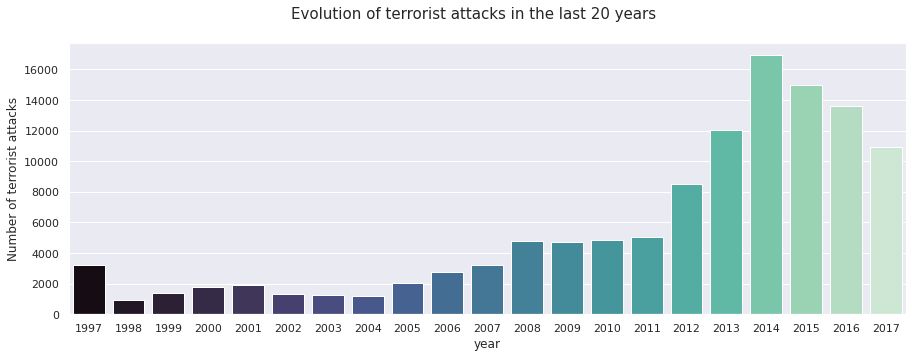

In [393]:
sns.set_theme()
sns.set(color_codes=True)

#Given that we already have the data grouped and the level of detailed is small enoguh to be handled by python, we are converting the dataframe to a pandas dataframe in order to 
#make easier the understansing of the data
Py_EventsPerYearDF = EventsPerYearDF.toPandas()

# Displaying a chart
fig, ax = plt.subplots(figsize=(15,5))

# Plotting the bar chart
ax = sns.barplot(x='year', y='NumEvents', data = Py_EventsPerYearDF, palette="mako")

# Adding titles
fig.suptitle('Evolution of terrorist attacks in the last 20 years', fontsize=15)
ax.set(ylabel = "Number of terrorist attacks")


#### what has been the increase from 1997 to 2017 in the number of terrorist attacks per year

In [425]:
y1997 = (EventsPerYearDF.filter(col("year") == 1997).select('NumEvents').collect())[0][0] #we do a collect because we know we are only extracting one row
y2017 = (EventsPerYearDF.filter(col("year") == 2017).select('NumEvents').collect())[0][0]

print(((y2017-y1997)/y1997)*100)

240.94463559587115


### 5.2. How have terrorist attacks evolved in the past 20 years in each region?

In [447]:
EventsYearRegionDF = (
                    TerrorismDF.select("year","region","eventid")
                     .groupBy("year","region")
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy("year","region")
                    )


my_window1 = Window.partitionBy('region').orderBy("year")
my_window4 = Window.partitionBy().orderBy("year")

EventsYearRegionDF = EventsYearRegionDF\
                        .withColumn('prev_year', f.lag(EventsYearRegionDF.NumEvents).over(my_window1))\
                        .withColumn('TotalYear', f.sum(EventsYearRegionDF.NumEvents).over(my_window4))


EventsYearRegionDF = EventsYearRegionDF\
                                .withColumn("%YearlyChange", round(((EventsYearRegionDF.NumEvents-EventsYearRegionDF.prev_year)/EventsYearRegionDF.prev_year)*100,2))\
                                .withColumn("%OfYear", round((EventsYearRegionDF.NumEvents/EventsYearRegionDF.TotalYear)*100,2))
                                    

EventsYearRegionDF.sort('year').show()

+----+--------------------+---------+---------+---------+-------------+-------+
|year|              region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+--------------------+---------+---------+---------+-------------+-------+
|1997|        Central Asia|       49|     null|     3197|         null|   1.53|
|1997|Central America &...|      117|     null|     3197|         null|   3.66|
|1997|  Sub-Saharan Africa|      279|     null|     3197|         null|   8.73|
|1997|      Western Europe|      349|     null|     3197|         null|  10.92|
|1997|Middle East & Nor...|      548|     null|     3197|         null|  17.14|
|1997|       North America|      137|     null|     3197|         null|   4.29|
|1997|Australasia & Oce...|        7|     null|     3197|         null|   0.22|
|1997|       South America|      774|     null|     3197|         null|  24.21|
|1997|           East Asia|       40|     null|     3197|         null|   1.25|
|1997|          South Asia|      490|   

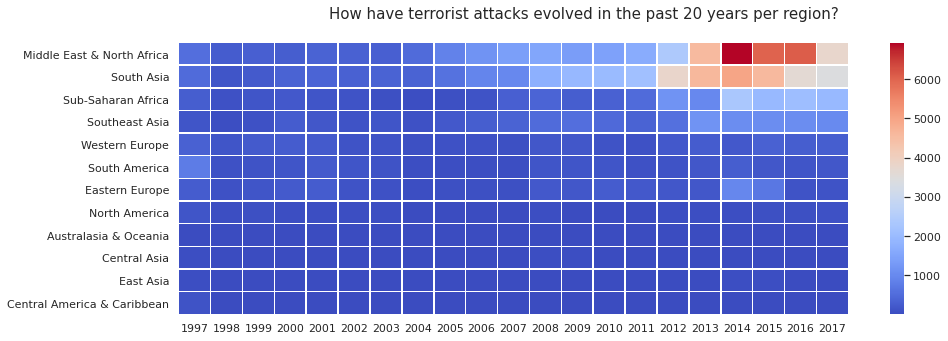

In [428]:
%matplotlib inline 

#Given that we already have the data grouped and the level of detailed is small enoguh to be handled by python, we are converting the dataframe to a pandas dataframe in order to 
#make easier the understansing of the data
Py_EventsYearRegionDF = EventsYearRegionDF.toPandas()
Py_EventsYearRegionDF.set_index("year", inplace = True)

df_pivot_temp1 = Py_EventsYearRegionDF.pivot_table(values = 'NumEvents', index = 'region', columns = 'year' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination
df_pivot_temp1 = df_pivot_temp1.sort_values([2017], ascending=False)

fig, ax = plt.subplots(figsize=(15, 5)) 
g = sns.heatmap(df_pivot_temp1,cmap="coolwarm",linewidths=.5,vmin=0.01)

# Adding titles
fig.suptitle('How have terrorist attacks evolved in the past 20 years per region?', fontsize=15)
# Remove labels beause the values are self explanatory.
ax.set_ylabel('')    
ax.set_xlabel('')

plt.show()

#### Detailed view of the behaviour of the attacks per Region, to make sure we are not missing something insteresting due to the dimension of the biggest regions

Text(0.5, 1.0, 'South America')

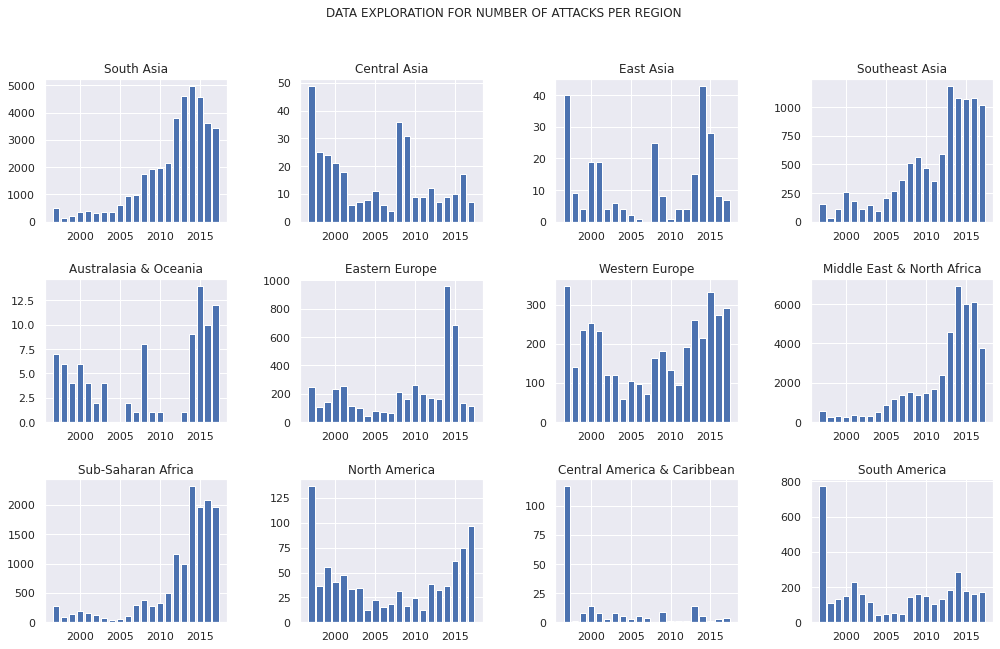

In [106]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize = (17, 10), sharex=False, sharey = False)

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('DATA EXPLORATION FOR NUMBER OF ATTACKS PER REGION')


ax1.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South Asia']['NumEvents'])
ax1.set_title('South Asia')

ax2.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central Asia']['NumEvents'])
ax2.set_title('Central Asia')

ax3.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='East Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='East Asia']['NumEvents'])
ax3.set_title('East Asia')

ax4.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Southeast Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Southeast Asia']['NumEvents'])
ax4.set_title('Southeast Asia')

ax5.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Australasia & Oceania'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Australasia & Oceania']['NumEvents'])
ax5.set_title('Australasia & Oceania')

ax6.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Eastern Europe'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Eastern Europe']['NumEvents'])
ax6.set_title('Eastern Europe')

ax7.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Western Europe'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Western Europe']['NumEvents'])
ax7.set_title('Western Europe')

ax8.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Middle East & North Africa'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Middle East & North Africa']['NumEvents'])
ax8.set_title('Middle East & North Africa')

ax9.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Sub-Saharan Africa'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Sub-Saharan Africa']['NumEvents'])
ax9.set_title('Sub-Saharan Africa')

ax10.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='North America'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='North America']['NumEvents'])
ax10.set_title('North America')

ax11.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central America & Caribbean'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central America & Caribbean']['NumEvents'])
ax11.set_title('Central America & Caribbean')

ax12.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South America'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South America']['NumEvents'])
ax12.set_title('South America')

    

#### Contribution per Region to the number global terrorist attacks

In [438]:
ContPerRegionDF = (
                    EventsYearRegionDF.select('region','NumEvents')
                     .groupBy('region')
                     .agg(sum('NumEvents').alias('NumEvents'))
                     .orderBy('region')
                    )

my_window4 = Window.partitionBy().orderBy()

ContPerRegionDF = ContPerRegionDF\
                        .withColumn('TotalYear', f.sum(ContPerRegionDF.NumEvents).over(my_window4))


ContPerRegionDF = ContPerRegionDF\
                                .withColumn("%", round((ContPerRegionDF.NumEvents/ContPerRegionDF.TotalYear)*100,2))


ContPerRegionDF.sort('%').show()

+--------------------+---------+---------+-----+
|              region|NumEvents|TotalYear|    %|
+--------------------+---------+---------+-----+
|Australasia & Oce...|       92|   117381| 0.08|
|Central America &...|      215|   117381| 0.18|
|           East Asia|      251|   117381| 0.21|
|        Central Asia|      326|   117381| 0.28|
|       North America|      878|   117381| 0.75|
|       South America|     3524|   117381|  3.0|
|      Western Europe|     3926|   117381| 3.34|
|      Eastern Europe|     4504|   117381| 3.84|
|      Southeast Asia|     9860|   117381|  8.4|
|  Sub-Saharan Africa|    13553|   117381|11.55|
|          South Asia|    38063|   117381|32.43|
|Middle East & Nor...|    42189|   117381|35.94|
+--------------------+---------+---------+-----+



#### Contribution of Middle East & North Africa in the number of terrorist attacks each year

In [448]:
EventsYearRegionDF.filter(EventsYearRegionDF.region == 'Middle East & North Africa').show(100)

+----+--------------------+---------+---------+---------+-------------+-------+
|year|              region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+--------------------+---------+---------+---------+-------------+-------+
|1997|Middle East & Nor...|      548|     null|     3197|         null|  17.14|
|1998|Middle East & Nor...|      247|      548|     4131|       -54.93|   5.98|
|1999|Middle East & Nor...|      316|      247|     5526|        27.94|   5.72|
|2000|Middle East & Nor...|      272|      316|     7340|       -13.92|   3.71|
|2001|Middle East & Nor...|      362|      272|     9246|        33.09|   3.92|
|2002|Middle East & Nor...|      326|      362|    10579|        -9.94|   3.08|
|2003|Middle East & Nor...|      310|      326|    11857|        -4.91|   2.61|
|2004|Middle East & Nor...|      492|      310|    13023|        58.71|   3.78|
|2005|Middle East & Nor...|      882|      492|    15040|        79.27|   5.86|
|2006|Middle East & Nor...|     1187|   

#### Contribution of South Asian in the number of terrorist attacks each year

In [449]:
EventsYearRegionDF.filter(EventsYearRegionDF.region == 'South Asia').show(100)

+----+----------+---------+---------+---------+-------------+-------+
|year|    region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+----------+---------+---------+---------+-------------+-------+
|1997|South Asia|      490|     null|     3197|         null|  15.33|
|1998|South Asia|      136|      490|     4131|       -72.24|   3.29|
|1999|South Asia|      225|      136|     5526|        65.44|   4.07|
|2000|South Asia|      357|      225|     7340|        58.67|   4.86|
|2001|South Asia|      385|      357|     9246|         7.84|   4.16|
|2002|South Asia|      334|      385|    10579|       -13.25|   3.16|
|2003|South Asia|      353|      334|    11857|         5.69|   2.98|
|2004|South Asia|      369|      353|    13023|         4.53|   2.83|
|2005|South Asia|      604|      369|    15040|        63.69|   4.02|
|2006|South Asia|      938|      604|    17798|         55.3|   5.27|
|2007|South Asia|      982|      938|    21040|         4.69|   4.67|
|2008|South Asia|   

### 5.3. Throughout the years, does it seem to have been a switch in the type of attacks the world has experience?


In [157]:
EventsYearAttackDF = (
                    TerrorismDF.select("year","AttackType","eventid")
                     .groupBy("year","AttackType")
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy("year","AttackType")
                    )

my_window2 = Window.partitionBy('year').orderBy("year")

EventsYearAttackDF = EventsYearAttackDF\
                        .withColumn('TotalAttackType', f.sum(EventsYearAttackDF.NumEvents).over(my_window2))

EventsYearAttackDF = EventsYearAttackDF\
                                .withColumn("%", round((EventsYearAttackDF.NumEvents/EventsYearAttackDF.TotalAttackType)*100,2))



EventsYearAttackDF.show()

+----+--------------------+---------+---------------+-----+
|year|          AttackType|NumEvents|TotalAttackType|    %|
+----+--------------------+---------+---------------+-----+
|2003|       Armed Assault|      315|           1278|24.65|
|2003|       Assassination|       88|           1278| 6.89|
|2003|   Bombing/Explosion|      689|           1278|53.91|
|2003|Facility/Infrastr...|       88|           1278| 6.89|
|2003|           Hijacking|        3|           1278| 0.23|
|2003|Hostage Taking (B...|        2|           1278| 0.16|
|2003|Hostage Taking (K...|       46|           1278|  3.6|
|2003|     Unarmed Assault|       20|           1278| 1.56|
|2003|             Unknown|       27|           1278| 2.11|
|2007|       Armed Assault|      849|           3242|26.19|
|2007|       Assassination|      140|           3242| 4.32|
|2007|   Bombing/Explosion|     1866|           3242|57.56|
|2007|Facility/Infrastr...|      115|           3242| 3.55|
|2007|           Hijacking|        7|   

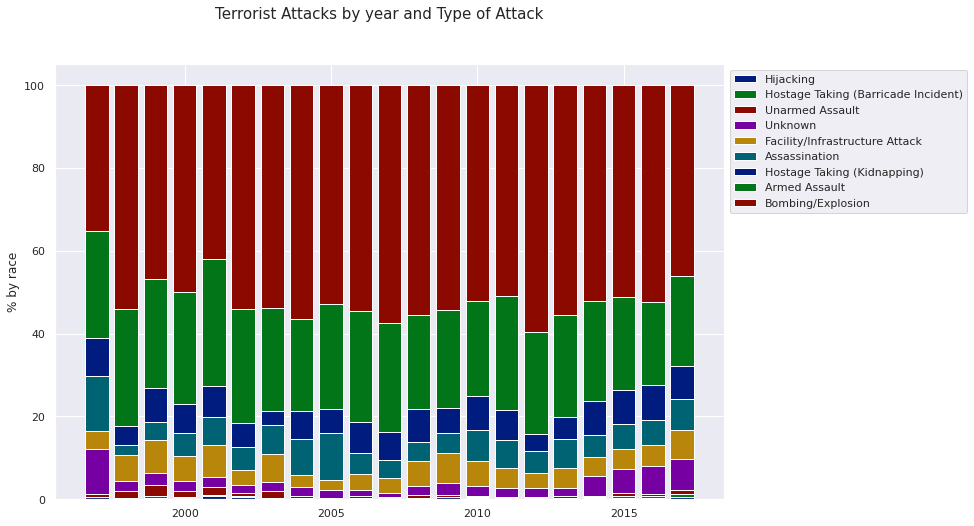

In [158]:
Py_EventsYearAttackDF = EventsYearAttackDF.toPandas()

df_pivot_temp3 = Py_EventsYearAttackDF.pivot_table(values = '%', index = 'year', columns = 'AttackType' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination

# We are creating a stackedbar chart by region, race and % of fatalities by race

plt.style.use('seaborn-dark-palette')

%matplotlib inline
fig, ax = plt.subplots(
        figsize = (12,8)
)
# Adding title
fig.suptitle('Terrorist Attacks by year and Type of Attack', fontsize = 15)

# Ploting the bar chart
ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hijacking'], label = 'Hijacking')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hostage Taking (Barricade Incident)'], 
       bottom =   df_pivot_temp3['Hijacking'],label = 'Hostage Taking (Barricade Incident)')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Unarmed Assault'], 
       bottom = df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Unarmed Assault')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Unknown'], 
       bottom = df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Unknown')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Facility/Infrastructure Attack'], 
       bottom = df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Facility/Infrastructure Attack')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Assassination'], 
       bottom = df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Assassination')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hostage Taking (Kidnapping)'], 
       bottom = df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Hostage Taking (Kidnapping)')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Armed Assault'], 
       bottom = df_pivot_temp3['Hostage Taking (Kidnapping)']
       + df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Armed Assault')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Bombing/Explosion'], 
       bottom = df_pivot_temp3['Armed Assault'] 
       + df_pivot_temp3['Hostage Taking (Kidnapping)']
       + df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Bombing/Explosion')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')

### 5.4. Have attacks become more lethal?

In [211]:
# 1. Let's enrich the DF with delay severity based on our categorization
KillWoundedDF = TerrorismDF\
   .withColumn('UnknownKillWound', when(col('nkill').isNull() | col('nWound').isNull() ,1 )
                                  .otherwise(0))



#### Número de muertos/heridos año a año debido a ataques terroristas

In [279]:
KillWoundedDF_Sum = (
                     KillWoundedDF.select("year","nkill","nwound",'UnknownKillWound')
                     .groupBy("year")
                     .agg(sum("nkill").alias("Fatalities"),sum("nwound").alias("Wounded"), sum("UnknownKillWound").alias("Unknown"))
                     .orderBy("year")
                    )

KillWoundedDF_Sum = KillWoundedDF_Sum \
                                .withColumn("Total", (KillWoundedDF_Sum.Fatalities + KillWoundedDF_Sum.Wounded))

KillWoundedDF_Sum = KillWoundedDF_Sum.\
                    join(EventsPerYearDF, KillWoundedDF_Sum.year == EventsPerYearDF.year, how='left')\
                    .select(KillWoundedDF_Sum.year,KillWoundedDF_Sum.Fatalities,KillWoundedDF_Sum.Wounded,KillWoundedDF_Sum.Unknown,KillWoundedDF_Sum.Total,EventsPerYearDF.NumEvents)
                   
KillWoundedDF_Sum = KillWoundedDF_Sum \
                                .withColumn("AverageFatalities", (KillWoundedDF_Sum.Fatalities / KillWoundedDF_Sum.NumEvents))\
                                .withColumn("AverageWounded", (KillWoundedDF_Sum.Wounded / KillWoundedDF_Sum.NumEvents))


KillWoundedDF_Sum.sort('year').show(30)

+----+----------+-------+-------+-------+---------+------------------+------------------+
|year|Fatalities|Wounded|Unknown|  Total|NumEvents| AverageFatalities|    AverageWounded|
+----+----------+-------+-------+-------+---------+------------------+------------------+
|1997|     10924| 9072.0|    203|19996.0|     3197| 3.416953393806694|2.8376603065373787|
|1998|      4688| 8183.0|    152|12871.0|      934| 5.019271948608137| 8.761241970021413|
|1999|      3393| 5341.0|    114| 8734.0|     1395| 2.432258064516129| 3.828673835125448|
|2000|      4403| 5869.0|    170|10272.0|     1814|2.4272326350606397|3.2353914002205073|
|2001|      7729|22774.0|    109|30503.0|     1906| 4.055089192025184|11.948583420776496|
|2002|      4805| 7162.0|     87|11967.0|     1333| 3.604651162790698| 5.372843210802701|
|2003|      3317| 7384.0|    104|10701.0|     1278|2.5954616588419404| 5.777777777777778|
|2004|      5743|12022.0|    116|17765.0|     1166| 4.925385934819897|10.310463121783876|
|2005|    

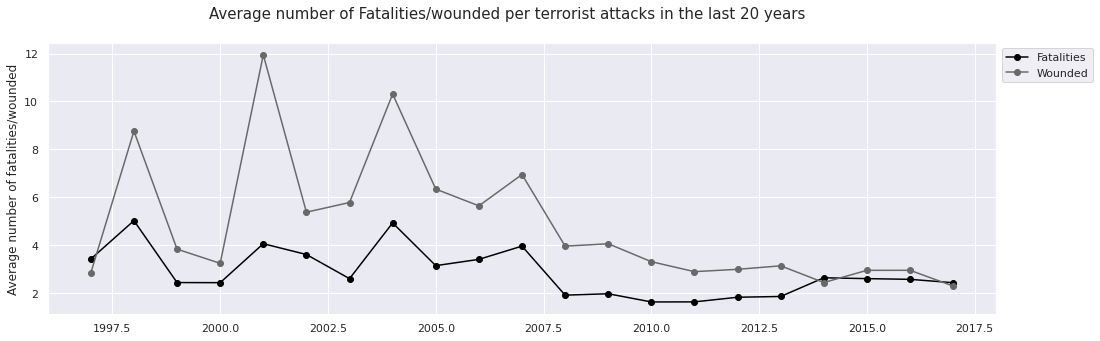

In [276]:
Py_KillWoundedDF_Sum = KillWoundedDF_Sum.toPandas()
Py_KillWoundedDF_Sum = Py_KillWoundedDF_Sum.sort_values(by='year')

# Displaying a bar chart
fig, ax = plt.subplots(figsize=(17,5))

# Adding titles
fig.suptitle('Average number of Fatalities/wounded per terrorist attacks in the last 20 years', fontsize=15)
ax.set_ylabel("Average number of fatalities/wounded")

# Plotting the bar chart
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['AverageFatalities'],color='black',label ='Fatalities', marker ='o')
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['AverageWounded'],color='dimgrey', label ='Wounded',marker ='o')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')


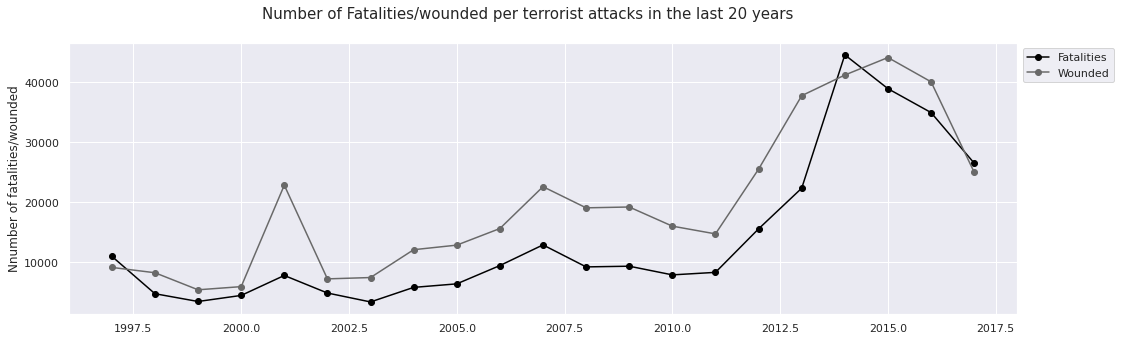

In [277]:
# Displaying a bar chart
fig, ax = plt.subplots(figsize=(17,5))

# Adding titles
fig.suptitle('Number of Fatalities/wounded per terrorist attacks in the last 20 years', fontsize=15)
ax.set_ylabel("Nnumber of fatalities/wounded")

# Plotting the bar chart
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['Fatalities'],color='black',label ='Fatalities', marker ='o')
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['Wounded'],color='dimgrey', label ='Wounded',marker ='o')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')

#### Número de muertos/heridos año a año por región debido a ataques terroristas

In [283]:
KillWoundedDF_Region = (
                     KillWoundedDF.select("year",'region',"nkill","nwound",'UnknownKillWound')
                     .groupBy("year",'region')
                     .agg(sum("nkill").alias("Fatalities"),sum("nwound").alias("Wounded"), sum("UnknownKillWound").alias("Unknown"))
                     .orderBy("year")
                    )

KillWoundedDF_Region = KillWoundedDF_Region \
                                .withColumn("Total", (KillWoundedDF_Region.Fatalities + KillWoundedDF_Region.Wounded))


KillWoundedDF_Sum.sort('year').show(30)

+----+----------+-------+-------+-------+---------+------------------+------------------+
|year|Fatalities|Wounded|Unknown|  Total|NumEvents| AverageFatalities|    AverageWounded|
+----+----------+-------+-------+-------+---------+------------------+------------------+
|1997|     10924| 9072.0|    203|19996.0|     3197| 3.416953393806694|2.8376603065373787|
|1998|      4688| 8183.0|    152|12871.0|      934| 5.019271948608137| 8.761241970021413|
|1999|      3393| 5341.0|    114| 8734.0|     1395| 2.432258064516129| 3.828673835125448|
|2000|      4403| 5869.0|    170|10272.0|     1814|2.4272326350606397|3.2353914002205073|
|2001|      7729|22774.0|    109|30503.0|     1906| 4.055089192025184|11.948583420776496|
|2002|      4805| 7162.0|     87|11967.0|     1333| 3.604651162790698| 5.372843210802701|
|2003|      3317| 7384.0|    104|10701.0|     1278|2.5954616588419404| 5.777777777777778|
|2004|      5743|12022.0|    116|17765.0|     1166| 4.925385934819897|10.310463121783876|
|2005|    

Text(0.5, 1.0, 'Number of Attacks')

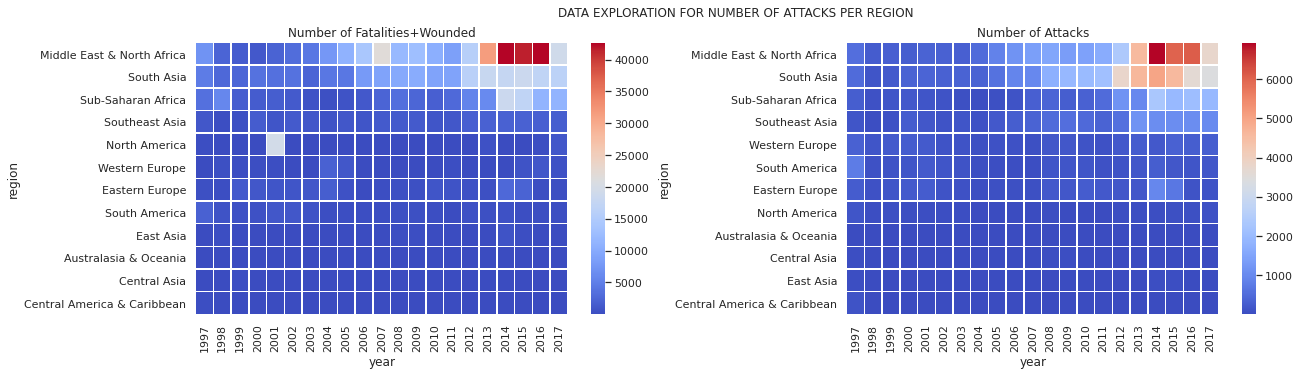

In [320]:
Py_KillWoundedDF_Region = KillWoundedDF_Region.toPandas()
Py_KillWoundedDF_Region.set_index("year", inplace = True)

df_pivot_temp4 = Py_KillWoundedDF_Region.pivot_table(values = 'Total', index = 'region', columns = 'year' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination
df_pivot_temp4 = df_pivot_temp4.sort_values([2017], ascending=False)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (20, 5), sharex=False, sharey = False)

ax1 = sns.heatmap(df_pivot_temp4,cmap="coolwarm",linewidths=.5,vmin=0.01, ax=ax1)
ax1.set_title('Number of Fatalities+Wounded')

ax2 = sns.heatmap(df_pivot_temp1,cmap="coolwarm",linewidths=.5,vmin=0.01, ax=ax2)
ax2.set_title('Number of Attacks')

### 5.5. ¿Do different regions have different type of attack?

In [362]:
AttacksRegionDF = (
                    TerrorismDF.select('region','AttackType','eventid')
                     .groupBy('region','AttackType')
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy('region','AttackType')
                    )

my_window3 = Window.partitionBy('region').orderBy('region')

AttacksRegionDF = AttacksRegionDF.withColumn('TotalRegion', f.sum(AttacksRegionDF.NumEvents).over(my_window3))

AttacksRegionDF = AttacksRegionDF.withColumn("%", AttacksRegionDF.NumEvents/AttacksRegionDF.TotalRegion)

AttacksRegionDF.sort('AttackType').show()

+--------------------+-------------+---------+-----------+--------------------+
|              region|   AttackType|NumEvents|TotalRegion|                   %|
+--------------------+-------------+---------+-----------+--------------------+
|       South America|Armed Assault|      647|       3524| 0.18359818388195231|
|Middle East & Nor...|Armed Assault|     7467|      42189|  0.1769892626039963|
|Central America &...|Armed Assault|       72|        215| 0.33488372093023255|
|       North America|Armed Assault|      186|        878| 0.21184510250569477|
|        Central Asia|Armed Assault|       67|        326| 0.20552147239263804|
|           East Asia|Armed Assault|       57|        251| 0.22709163346613545|
|      Eastern Europe|Armed Assault|     1170|       4504| 0.25976909413854354|
|          South Asia|Armed Assault|     9333|      38063| 0.24519874944171505|
|Australasia & Oce...|Armed Assault|       11|         92| 0.11956521739130435|
|      Western Europe|Armed Assault|    

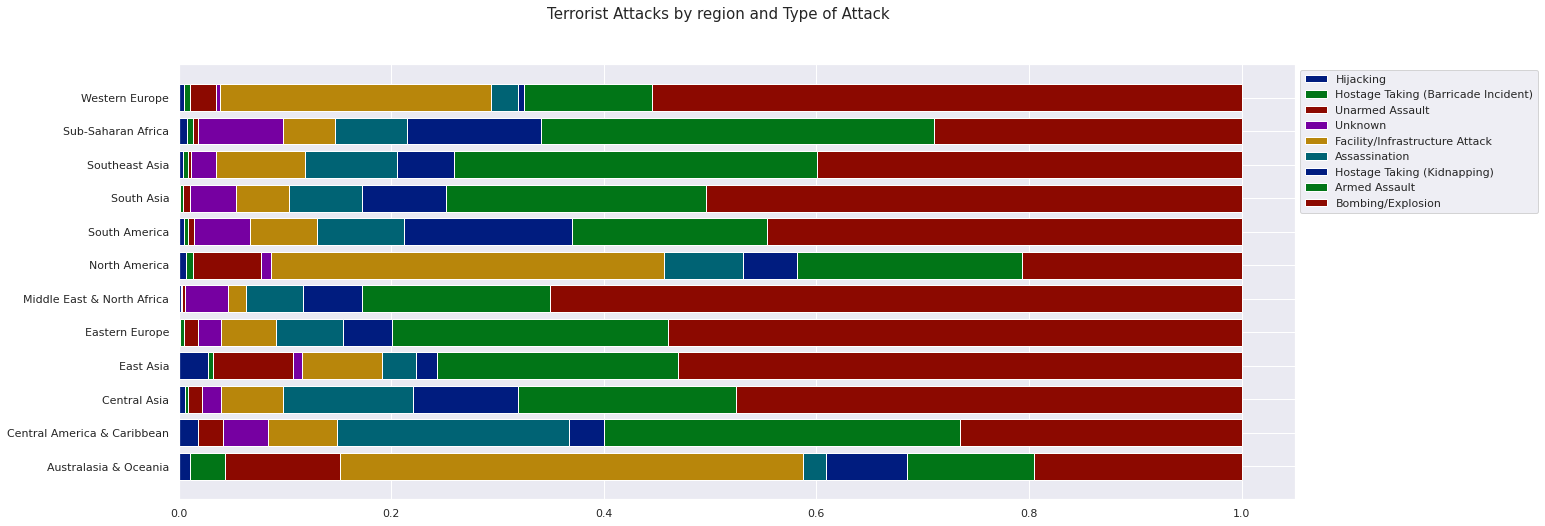

In [363]:
Py_AttacksRegionDF = AttacksRegionDF.toPandas()

df_pivot_temp5 = Py_AttacksRegionDF.pivot_table(values = '%', index = 'region', columns = 'AttackType' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination


plt.style.use('seaborn-dark-palette')

%matplotlib inline
fig, ax = plt.subplots(
        figsize = (20,8)
)
# Adding title
fig.suptitle('Terrorist Attacks by region and Type of Attack', fontsize = 15)

# Ploting the bar chart
ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hijacking'], label = 'Hijacking')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hostage Taking (Barricade Incident)'], 
       left =   df_pivot_temp5['Hijacking'],label = 'Hostage Taking (Barricade Incident)')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Unarmed Assault'], 
       left = df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Unarmed Assault')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Unknown'], 
       left = df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Unknown')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Facility/Infrastructure Attack'], 
       left = df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Facility/Infrastructure Attack')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Assassination'], 
       left = df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Assassination')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hostage Taking (Kidnapping)'], 
       left = df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Hostage Taking (Kidnapping)')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Armed Assault'], 
       left = df_pivot_temp5['Hostage Taking (Kidnapping)']
       + df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Armed Assault')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Bombing/Explosion'], 
       left = df_pivot_temp5['Armed Assault'] 
       + df_pivot_temp5['Hostage Taking (Kidnapping)']
       + df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Bombing/Explosion')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')
